This notebook is based on [this example from Francois Chollet](https://github.com/fchollet/keras/blob/master/examples/reuters_mlp.py).

Train and evaluate a simple MLP on the 20 newsgroups topic classification task.

In [1]:
import numpy as np
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Input
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
max_words = 1000
batch_size = 32
epochs = 5

In [3]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')

In [4]:
print(newsgroups_train["data"][0])

From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----







In [5]:
print("Preparing the Tokenizer...")
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(newsgroups_train["data"])

Preparing the Tokenizer...


In [6]:
print('Vectorizing sequence data...')
x_train = tokenizer.texts_to_matrix(newsgroups_train["data"], mode='binary')
x_test = tokenizer.texts_to_matrix(newsgroups_test["data"], mode='binary')
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Vectorizing sequence data...
x_train shape: (11314, 1000)
x_test shape: (7532, 1000)


In [7]:
x_train

array([[ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  1.,  0.,  0.],
       ..., 
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1.,  1., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [8]:
num_classes = np.max(newsgroups_train["target"]) + 1
print(num_classes, 'classes')

20 classes


In [9]:
print('Convert class vector to binary class matrix '
      '(for use with categorical_crossentropy)')
y_train = keras.utils.to_categorical(newsgroups_train["target"], num_classes)
y_test = keras.utils.to_categorical(newsgroups_test["target"], num_classes)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

Convert class vector to binary class matrix (for use with categorical_crossentropy)
y_train shape: (11314, 20)
y_test shape: (7532, 20)


In [10]:
y_train

array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       ..., 
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  1.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])

In [11]:
print('Building model sequentially 1...')
model = Sequential()
model.add(Dense(512, input_shape=(max_words,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes))
model.add(Activation('softmax'))

Building model sequentially 1...


In [12]:
print('Building model sequentially 2...')
model = Sequential([
          Dense(512, input_shape=(max_words,)),
          Activation('relu'),
          Dropout(0.5),
          Dense(num_classes),
          Activation('softmax')
        ])

Building model sequentially 2...


In [13]:
model.layers

In [14]:
print(model.to_yaml())

backend: tensorflow
class_name: Sequential
config:
- class_name: Dense
  config:
    activation: linear
    activity_regularizer: null
    batch_input_shape: !!python/tuple [null, 1000]
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    dtype: float32
    kernel_constraint: null
    kernel_initializer:
      class_name: VarianceScaling
      config: {distribution: uniform, mode: fan_avg, scale: 1.0, seed: null}
    kernel_regularizer: null
    name: dense_3
    trainable: true
    units: 512
    use_bias: true
- class_name: Activation
  config: {activation: relu, name: activation_3, trainable: true}
- class_name: Dropout
  config: {name: dropout_2, rate: 0.5, trainable: true}
- class_name: Dense
  config:
    activation: linear
    activity_regularizer: null
    bias_constraint: null
    bias_initializer:
      class_name: Zeros
      config: {}
    bias_regularizer: null
    kernel_constraint: null
    kernel_initial

In [15]:
print('Building model functionally...')
a = Input(shape=(max_words,))
b = Dense(512)(a)
b = Activation('relu')(b)
b = Dropout(0.5)(b)
b = Dense(num_classes)(b)
b = Activation('softmax')(b)
model = Model(inputs=a, outputs=b)

Building model functionally...


In [16]:
from keras.models import model_from_yaml

yaml_string = model.to_yaml()
model = model_from_yaml(yaml_string)

In [17]:
! pip install pydot-ng

You are using pip version 8.1.2, however version 9.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [27]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

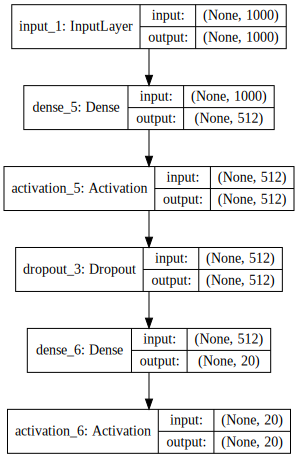

In [28]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

In [23]:
from keras.objectives import categorical_crossentropy
from keras import backend as K

epsilon = 1.0e-9
def custom_objective(y_true, y_pred):
    '''Yet another crossentropy'''
    y_pred = K.clip(y_pred, epsilon, 1.0 - epsilon)
    y_pred /= K.sum(y_pred, axis=-1, keepdims=True)
    cce = categorical_crossentropy(y_pred, y_true)
    return cce

In [24]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [25]:
model.compile(loss=custom_objective,
              optimizer='adam',
              metrics=['accuracy'])

In [26]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1)

Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 6s - loss: 11.2602 - acc: 0.3476 - val_loss: 8.1297 - val_acc: 0.5442
Epoch 2/5
10182/10182 [==============================] - 5s - loss: 7.1478 - acc: 0.5968 - val_loss: 6.9277 - val_acc: 0.5998
Epoch 3/5
10182/10182 [==============================] - 5s - loss: 5.6592 - acc: 0.6782 - val_loss: 5.8904 - val_acc: 0.6564
Epoch 4/5
10182/10182 [==============================] - 5s - loss: 4.8580 - acc: 0.7209 - val_loss: 5.7133 - val_acc: 0.6643
Epoch 5/5
10182/10182 [==============================] - 5s - loss: 4.5376 - acc: 0.7376 - val_loss: 5.5546 - val_acc: 0.6687


In [24]:
from keras.callbacks import EarlyStopping  
early_stopping=EarlyStopping(monitor='val_loss')  

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[early_stopping])

Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 6s - loss: 5.0572 - acc: 0.6996 - val_loss: 5.9746 - val_acc: 0.6396
Epoch 2/5
10182/10182 [==============================] - 6s - loss: 4.8309 - acc: 0.7135 - val_loss: 5.9775 - val_acc: 0.6396


In [25]:
from keras.callbacks import TensorBoard  
tensorboard=TensorBoard(log_dir='./logs', write_graph=True, write_images=True)

history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_split=0.1,
                    callbacks=[tensorboard])

Train on 10182 samples, validate on 1132 samples
Epoch 1/5
10182/10182 [==============================] - 5s - loss: 4.6762 - acc: 0.7209 - val_loss: 5.8910 - val_acc: 0.6475
Epoch 2/5
10182/10182 [==============================] - 5s - loss: 4.5583 - acc: 0.7272 - val_loss: 5.8414 - val_acc: 0.6493
Epoch 3/5
10182/10182 [==============================] - 5s - loss: 4.4485 - acc: 0.7323 - val_loss: 5.9157 - val_acc: 0.6422
Epoch 4/5
10182/10182 [==============================] - 5s - loss: 4.3723 - acc: 0.7361 - val_loss: 5.9310 - val_acc: 0.6369
Epoch 5/5
10182/10182 [==============================] - 5s - loss: 4.3307 - acc: 0.7380 - val_loss: 5.7791 - val_acc: 0.6511


In [26]:
score = model.evaluate(x_test, y_test,
                       batch_size=batch_size, verbose=1)
print('\n')
print('Test score:', score[0])
print('Test accuracy:', score[1])

7328/7532 [============================>.] - ETA: 0s

Test score: 7.05705657565
Test accuracy: 0.572623473149
